In [1]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 12*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

tf.compat.v1.enable_eager_execution()

import numpy as np
import imageio
import json
import random
import time
import pprint

import matplotlib.pyplot as plt

import run_nerf

from load_llff import load_llff_data
from load_deepvoxels import load_dv_data
from load_blender import load_blender_data


2023-09-10 20:25:37.103577: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-10 20:25:37.205265: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-10 20:25:37.671696: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-10 20:25:37.671737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[]


2023-09-10 20:25:38.218575: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-10 20:25:38.218612: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: battlestation
2023-09-10 20:25:38.218622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: battlestation
2023-09-10 20:25:38.218709: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.125.6
2023-09-10 20:25:38.218734: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.125.6
2023-09-10 20:25:38.218740: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.125.6


In [2]:
# basedir = './logs'
basedir = '/home/derm/nerf/logs' #pull data from desktop (too big to store on git repo)
expname = 'fern_example'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())
parser = run_nerf.config_parser()

# args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_200000.npy')))
args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_200000.npy')))
print('loaded args')

images, poses, bds, render_poses, i_test = load_llff_data(args.datadir, args.factor, 
                                                          recenter=True, bd_factor=.75, 
                                                          spherify=args.spherify)
H, W, focal = poses[0,:3,-1].astype(np.float32)

H = int(H)
W = int(W)
hwf = [H, W, focal]

images = images.astype(np.float32)
poses = poses.astype(np.float32)

if args.no_ndc:
    near = tf.reduce_min(bds) * .9
    far = tf.reduce_max(bds) * 1.
else:
    near = 0.
    far = 1.



Args:
datadir = /home/derm/nerf/data/nerf_llff_data/fern
dataset_type = llff
factor = 4

no_batching = False
i_embed = 0
N_samples = 64
N_importance = 128
use_viewdirs = True
lrate_decay = 250

llffhold = 8

N_rand = 4096
loaded args
Loaded image data (756, 1008, 3, 20) [ 756.         1008.          815.13158322]
Loaded /home/derm/nerf/data/nerf_llff_data/fern 16.985296178676084 80.00209740336334
recentered (3, 5)
[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00  1.4901161e-09]
 [ 0.0000000e+00  1.0000000e+00 -1.8730975e-09 -9.6857544e-09]
 [-0.0000000e+00  1.8730975e-09  1.0000000e+00  0.0000000e+00]]
Data:
(20, 3, 5) (20, 756, 1008, 3) (20, 2)
HOLDOUT view is 12


In [3]:
len(render_poses)

120

MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)


2023-09-10 20:25:39.601208: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Found ckpts ['/home/derm/nerf/logs/fern_example/model_200000.npy']
Reloading from /home/derm/nerf/logs/fern_example/model_200000.npy
Resetting step to 200001
Reloading fine from /home/derm/nerf/logs/fern_example/model_fine_200000.npy
Render kwargs:
{'N_importance': 128,
 'N_samples': 64,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'network_fine': <keras.engine.functional.Functional object at 0x7f67c99b4bb0>,
 'network_fn': <keras.engine.functional.Functional object at 0x7f67c997cd00>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x7f67bcb8ba60>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': False}


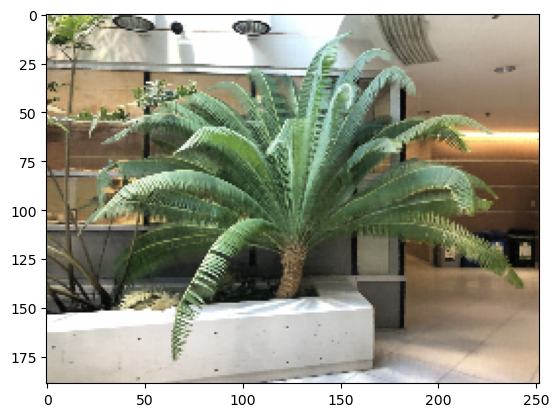

In [4]:
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)


down = 4
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 0

c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
img = np.clip(test[0],0,1)
plt.imshow(img)
plt.show()

In [ ]:
down = 8 # trade off resolution+aliasing for render speed to make this video faster
frames = []
for i, c2w in enumerate(render_poses):
# for i, c2w in enumerate(render_poses[:len(render_poses)//2]): #just render 10 frames
    if i%8==0: print(i)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frames.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
print('done, saving')
f = 'logs/fern_example/video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=8)

from IPython.display import Video
Video(f, height=320)

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import matplotlib.pyplot as plt
import numpy as np


def f(x, y, z):
    
    c2w = tf.convert_to_tensor([
        [1,0,0,x],
        [0,1,0,y],
        [0,0,1,z],
        [0,0,0,1],
    ], dtype=tf.float32)
    
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w, **render_kwargs_fast)
    img = np.clip(test[0],0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda : widgets.FloatSlider(
    value=0.,
    min=-1.,
    max=1.,
    step=.01,
)

names = ['x', 'y', 'z']
    
interactive_plot = interactive(f, **{n : sldr() for n in names})
interactive_plot